# <center>Organizaci&oacute;n de Datos</center>
#### <center>C&aacute;tedra Ing. Rodriguez, Juan Manuel </center>

## <center>Trabajo Práctico 1 : Propiedades en Venta</center>
## <center>Parte 4</center>
### <center> Grupo 22 </center>
### <center> Integrantes: </center>
##### <center> Federico Martin Forte,  Francisco Sobral,  Ian Klaus von der Heyde,  Juan Pablo Aschieri,  Joaquin Rivero  </center>

# Carga de Datos y librerías

In [236]:
import pandas as pd

import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gp

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score

from pyclustertend import hopkins
from yellowbrick.cluster import SilhouetteVisualizer

from IPython.display import Image
from sklearn.neighbors import KNeighborsRegressor
from sklearn import metrics

In [237]:
viviendas_caba_train=pd.read_csv('./Datasets/viviendas_caba_train.csv').copy()
viviendas_caba_test=pd.read_csv('./Datasets/viviendas_caba_test.csv').copy()

pca_df=pd.read_csv('./Datasets/pca_properati_argentina_2021.csv').copy()

poly = gp.read_file(r'./Datasets/barrios_procesados.geojson')

# 2. Regresión

## Modelo 1: KNN

### Dataset completo:

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

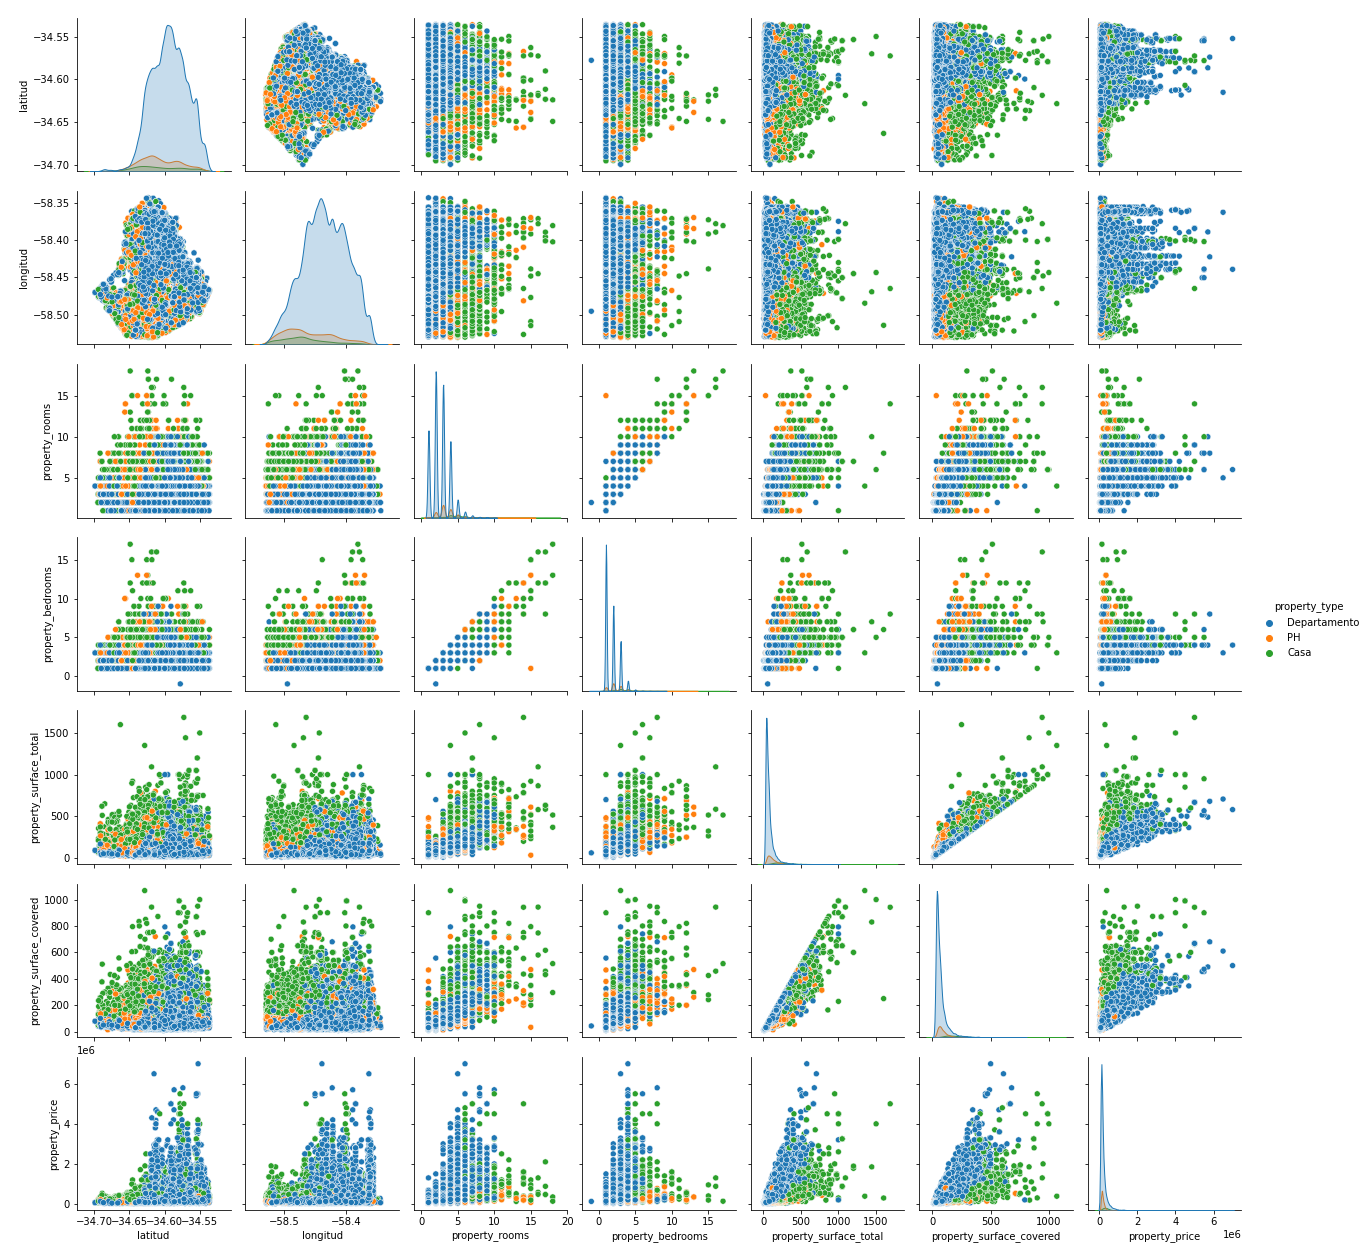

In [238]:
Image(filename = './Figures/paiplot_dataset_procesado.png', width=1500, height=1500)

In [239]:
#Heatmap correlación
viviendas_caba_train.corr().style.background_gradient(cmap='coolwarm')

,latitud,longitud,property_rooms,property_bedrooms,property_surface_total,property_surface_covered,property_price
latitud,1.000000,-0.142706,-0.028074,-0.030294,0.020934,0.039337,0.165821
longitud,-0.142706,1.000000,0.012788,0.010046,-0.003481,0.048280,0.126865
property_rooms,-0.028074,0.012788,1.000000,0.926374,0.758225,0.771415,0.524626
property_bedrooms,-0.030294,0.010046,0.926374,1.000000,0.726663,0.737603,0.483506
property_surface_total,0.020934,-0.003481,0.758225,0.726663,1.000000,0.954711,0.722198
property_surface_covered,0.039337,0.048280,0.771415,0.737603,0.954711,1.000000,0.773876
property_price,0.165821,0.126865,0.524626,0.483506,0.722198,0.773876,1.000000


**Correlación**

gracias al pairplot y a la matriz de correlacion vemos que el precio está más relacionado con la superficie total y cubierta, por lo que las elegimos como variables predictoras

In [240]:
#selecciono variables regresoras y a predecir
X_train = viviendas_caba_train[['property_surface_total', 'property_surface_covered']]
X_test = viviendas_caba_test[['property_surface_total', 'property_surface_covered']]
y_train = viviendas_caba_train.property_price
y_test = viviendas_caba_test.property_price

In [241]:
#Heatmap correlación
X_train.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered
property_surface_total,1.000000,0.954711
property_surface_covered,0.954711,1.000000


<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

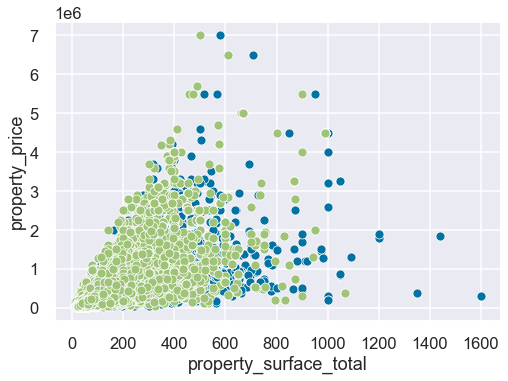

In [242]:
sns.scatterplot(x=X_train.property_surface_total,y=y_train)
sns.scatterplot(x=X_train.property_surface_covered,y=y_train)

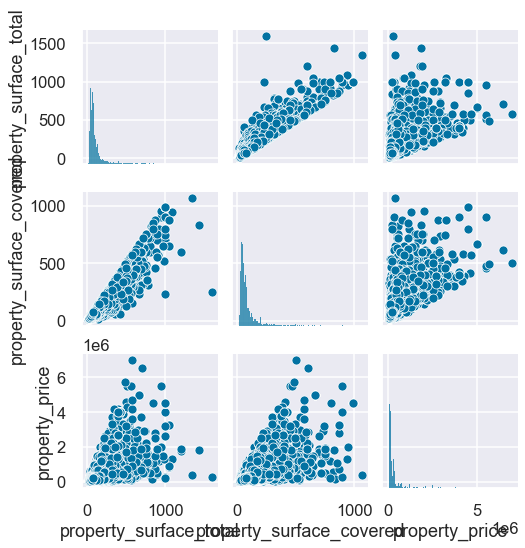

In [243]:
#Grafico de a pares incluyendo variable a predecir
xy_train_sin_outliers = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train_sin_outliers)

Optimizamos los parámetros usando random search cross validation

In [244]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='r2', n_iter=10, random_state=5)

rand.fit(X_train, y_train)
rand.cv_results_['mean_test_score']

array([0.68151184, 0.61777431, 0.66255793, 0.64446219, 0.7028535 ,
       0.61885344, 0.65942681, 0.69771217, 0.70206556, 0.703341  ])

In [245]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 29, 'metric': 'chebyshev', 'algorithm': 'brute'}
0.7033410004491613


In [246]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
# View
performance.head()

,Valor Real,Prediccion,Error
0,140000.0,111568.965517,28431.034483
1,69900.0,113248.275862,-43348.275862
2,75900.0,71904.827586,3995.172414
3,315000.0,139511.793103,175488.206897
4,79000.0,78096.551724,903.448276


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


[Text(0.5, 1.0, 'Valor Real vs Predicción'),
 Text(0.5, 0, 'Valor Real'),
 Text(0, 0.5, 'Prediccion')]

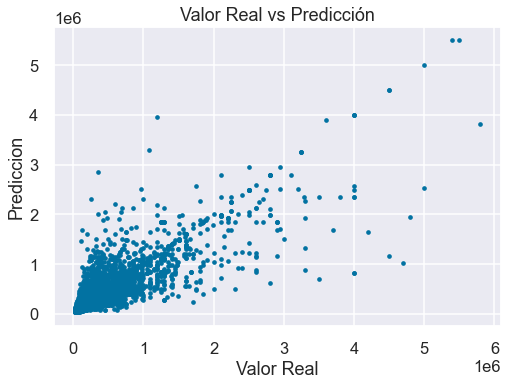

In [247]:
performance.plot.scatter(x="Valor Real", y="Prediccion", s=10).set(title="Valor Real vs Predicción",xlabel='Valor Real',ylabel='Prediccion') 


In [248]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(X_test)

#Coef. de Determinación R2
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


0.7266365805399779

In [249]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 25565387246.48451
El error (rmse) de test es: 159891.79855916472


Conclusiones KNN

¿Cuántos
folds utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?...

EXPOLICAR CADA METRICA

### Dataset con reduccion de dimensionalidad:

Como en el parte 1 ya limpiamos los valores atípicos no tenemos que hacerlo nuevamente para esta parte

In [224]:
"""pairplot_fig_procesado = sns.pairplot(pca_df).figure
pairplot_fig_procesado.savefig('./Figures/paiplot_dataset_procesado_con_reduccion_pca')"""

"pairplot_fig_procesado = sns.pairplot(pca_df).figure\npairplot_fig_procesado.savefig('./Figures/paiplot_dataset_procesado_con_reduccion_pca')"

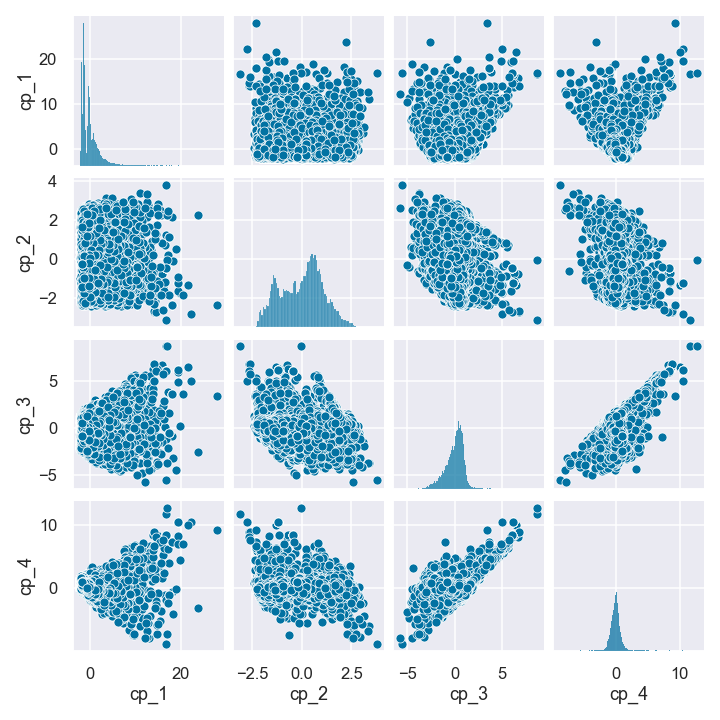

In [226]:
Image(filename = './Figures/paiplot_dataset_procesado_con_reduccion_pca.png', width=1000, height=1000)

In [228]:
#Heatmap correlación
pca_df.corr().style.background_gradient(cmap='coolwarm')

,cp_1,cp_2,cp_3,cp_4
cp_1,1.000000,0.000000,-0.000000,-0.000000
cp_2,0.000000,1.000000,-0.000000,-0.000000
cp_3,-0.000000,-0.000000,1.000000,0.000000
cp_4,-0.000000,-0.000000,0.000000,1.000000


**Correlación**

gracias al pairplot y a la matriz de correlacion vemos que el precio está más relacionado con la superficie total y cubierta, por lo que las elegimos como variables predictoras

In [ ]:
#selecciono variables regresoras y a predecir
X_train = viviendas_caba_train[['property_surface_total', 'property_surface_covered']]
X_test = viviendas_caba_test[['property_surface_total', 'property_surface_covered']]
y_train = viviendas_caba_train.property_price
y_test = viviendas_caba_test.property_price

In [ ]:
#Heatmap correlación
X_train.corr().style.background_gradient(cmap='coolwarm')

,property_surface_total,property_surface_covered
property_surface_total,1.000000,0.954711
property_surface_covered,0.954711,1.000000


<AxesSubplot:xlabel='property_surface_total', ylabel='property_price'>

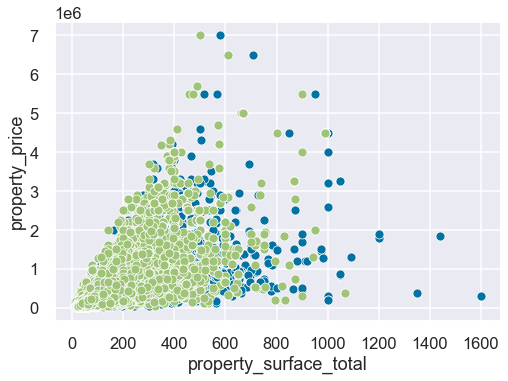

In [ ]:
sns.scatterplot(x=X_train.property_surface_total,y=y_train)
sns.scatterplot(x=X_train.property_surface_covered,y=y_train)

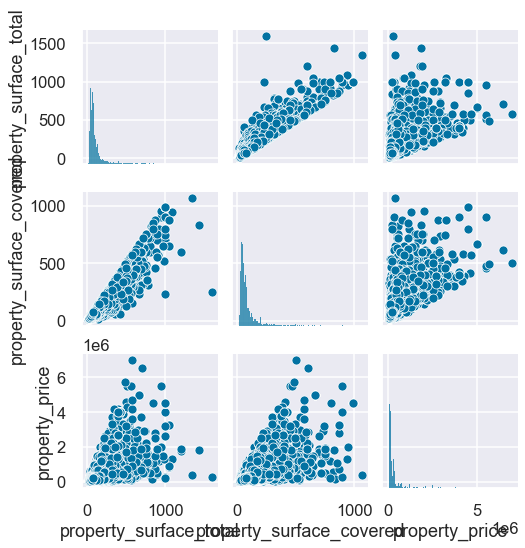

In [ ]:
#Grafico de a pares incluyendo variable a predecir
xy_train_sin_outliers = pd.concat([X_train, y_train], axis=1)
sns.pairplot(xy_train_sin_outliers)

Optimizamos los parámetros usando random search cross validation

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

#Grilla de Parámetros
params_grid={ 'n_neighbors':range(1,30), 
              'weights':['distance','uniform'],
              'algorithm':['ball_tree', 'kd_tree', 'brute'],
              'metric':['euclidean','manhattan','chebyshev']
             }

#Clasificador KNN
knn=KNeighborsRegressor()

#Random Search con 10 Folds y 10 iteraciones
rand = RandomizedSearchCV(knn, params_grid, cv=10, scoring='r2', n_iter=10, random_state=5)

rand.fit(X_train, y_train)
rand.cv_results_['mean_test_score']

array([0.68151184, 0.61777431, 0.66255793, 0.64446219, 0.7028535 ,
       0.61885344, 0.65942681, 0.69771217, 0.70206556, 0.703341  ])

In [ ]:
#Mejores hiperparametros
print(rand.best_params_)
#Mejor métrica
print(rand.best_score_)

{'weights': 'distance', 'n_neighbors': 29, 'metric': 'chebyshev', 'algorithm': 'brute'}
0.7033410004491613


In [ ]:
# Performance
performance = pd.DataFrame({'Valor Real': y_test,
                            'Prediccion': y_pred,
                            'Error': y_test - y_pred})
# View
performance.head()

,Valor Real,Prediccion,Error
0,140000.0,111568.965517,28431.034483
1,69900.0,113248.275862,-43348.275862
2,75900.0,71904.827586,3995.172414
3,315000.0,139511.793103,175488.206897
4,79000.0,78096.551724,903.448276


In [ ]:
#Mejor estimador
best_knn=rand.best_estimator_

#Predicción con mejor estimador
y_pred=best_knn.predict(X_test)

#Coef. de Determinación R2
from sklearn.metrics import r2_score
r2_score(y_test, y_pred)


0.7266365805399779

In [ ]:
#Mean Square Error
mse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = True
       )

print(f"El error (mse) de test es: {mse}")

#Root Mean Square Error
rmse = metrics.mean_squared_error(
        y_true  = y_test,
        y_pred  = y_pred,
        squared = False
       )

print(f"El error (rmse) de test es: {rmse}")

El error (mse) de test es: 25565387246.48451
El error (rmse) de test es: 159891.79855916472


Conclusiones KNN

¿Cuántos
folds utilizaron? ¿Qué métrica consideran adecuada para buscar los parámetros?...

EXPOLICAR CADA METRICA

## Modelo 2: XGBoost